In [ ]:
# tweak good_columns

In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [3]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df



In [4]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [5]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [6]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 373.16 Mb (50.0% reduction)
Mem. usage decreased to 195.94 Mb (48.8% reduction)


In [9]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
    df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
    df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
    df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
    df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
    df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
    df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
    df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
    df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
    df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
    df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
    df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
    df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
    df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
    df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
    df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min', 'skew', 'median']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [10]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 14029.03 Mb (-36.1% reduction)


In [11]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 7535.15 Mb (-36.2% reduction)


In [12]:
train.to_csv('../cache/train2.csv', index=False)
test.to_csv('../cache/test2.csv', index=False)

In [2]:
train = pd.read_csv('../cache/train2.csv')
test = pd.read_csv('../cache/test2.csv')

In [3]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 13749.09 Mb (65.1% reduction)
Mem. usage decreased to 7390.63 Mb (65.1% reduction)


In [5]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_distx_mean',
'molecule_disty_mean',
'molecule_distz_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_distx_min',
'molecule_disty_min',
'molecule_distz_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_distx_max',
'molecule_disty_max',
'molecule_distz_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

In [6]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [7]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [8]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [9]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [10]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
X_test = test[good_columns].copy()

In [11]:
del train, test

In [12]:
import gc
gc.collect()

60

In [13]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Sun Jun  9 04:31:41 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11407	valid_1's l1: 1.15801
[1000]	training's l1: 0.989552	valid_1's l1: 1.06686
[1500]	training's l1: 0.911364	valid_1's l1: 1.01759
[2000]	training's l1: 0.852437	valid_1's l1: 0.983504
[2500]	training's l1: 0.805944	valid_1's l1: 0.960255
[3000]	training's l1: 0.766275	valid_1's l1: 0.941491
[3500]	training's l1: 0.73198	valid_1's l1: 0.926191
[4000]	training's l1: 0.701896	valid_1's l1: 0.91441
[4500]	training's l1: 0.674726	valid_1's l1: 0.904186
[5000]	training's l1: 0.650126	valid_1's l1: 0.895733
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.650126	valid_1's l1: 0.895733
Fold 2 started at Sun Jun  9 04:49:18 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.11542	valid_1's l1: 1.16127
[1000]	training's l1: 0.988715	valid_1's l1: 1.06788
[1500]	training's l1: 0.910485	valid_1's l1: 1.01

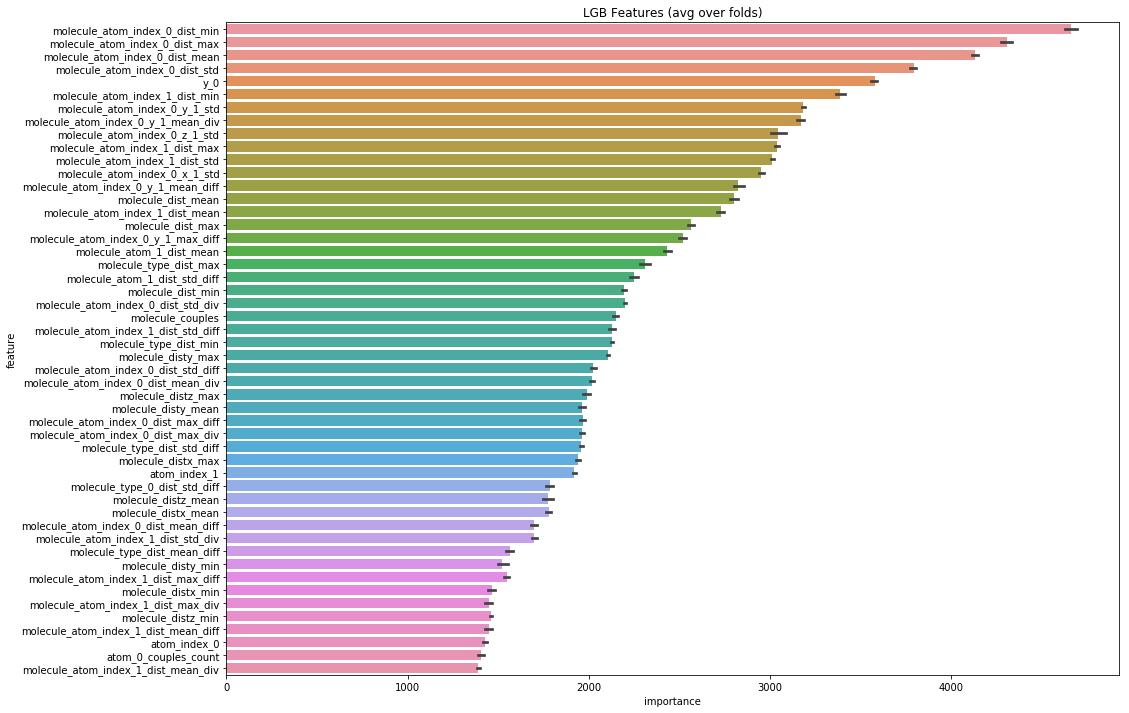

In [14]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [18]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('../submissions/sub3.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,11.852834437443544
1,4658148,194.602924416023939
2,4658149,6.966904946625985
3,4658150,186.787339010735565
4,4658151,5.713474223083945


In [19]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub3.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:15<00:00, 4.37MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 346 ms, sys: 555 ms, total: 900 ms
Wall time: 19.7 s


In [20]:
from time import sleep
sleep(40)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          
